# Part2: RandomForest Model Training

<h3>2.1 Baseline Model </h3>

We first make a random forset model as a baseline model

In [1]:
import pandas as pd
import numpy as np
import os
import json
import logging

from sklearn.metrics import mean_squared_error

from data import DATA_DIR

logger = logging.getLogger()
PRE_DIR = os.path.join(DATA_DIR, "pre")
RESULT_DIR = os.path.join(DATA_DIR, "result")

We do not need card id anynore since we don't have to merge tables

In [2]:
train = pd.read_csv(os.path.join(PRE_DIR, "train_groupby.csv"))
test = pd.read_csv(os.path.join(PRE_DIR, "test_groupby.csv"))

features = train.columns.tolist()
features.remove('target')
features.remove('card_id')

features

['first_active_month',
 'feature_1',
 'feature_2',
 'feature_3',
 'month_lag_nunique_hist_x',
 'month_lag_mean_hist_x',
 'month_lag_min_hist_x',
 'month_lag_max_hist_x',
 'month_lag_var_hist_x',
 'month_lag_skew_hist_x',
 'month_lag_sum_hist_x',
 'installments_nunique_hist_x',
 'installments_mean_hist_x',
 'installments_min_hist_x',
 'installments_max_hist_x',
 'installments_var_hist_x',
 'installments_skew_hist_x',
 'installments_sum_hist_x',
 'purchase_amount_nunique_hist_x',
 'purchase_amount_mean_hist_x',
 'purchase_amount_min_hist_x',
 'purchase_amount_max_hist_x',
 'purchase_amount_var_hist_x',
 'purchase_amount_skew_hist_x',
 'purchase_amount_sum_hist_x',
 'numerical_1_nunique_hist_x',
 'numerical_1_mean_hist_x',
 'numerical_1_min_hist_x',
 'numerical_1_max_hist_x',
 'numerical_1_var_hist_x',
 'numerical_1_skew_hist_x',
 'numerical_1_sum_hist_x',
 'numerical_2_nunique_hist_x',
 'numerical_2_mean_hist_x',
 'numerical_2_min_hist_x',
 'numerical_2_max_hist_x',
 'numerical_2_var_his

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
# The parameter are randomly picked,
# and we leave the best solution because it was too slow
PARAMETER_SPACE = {
    "n_estimators": [9],
    "min_samples_leaf": [4],
    "min_samples_split": [2],
    "max_depth": [9],
    "max_features": [80]
}

In [5]:
clf = RandomForestRegressor(criterion='squared_error', n_jobs=16, random_state=42)
grid = GridSearchCV(clf, PARAMETER_SPACE, cv=2, scoring='neg_mean_squared_error')
grid.fit(train[features].values, train['target'].values)

GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=16, random_state=42),
             param_grid={'max_depth': [9], 'max_features': [80],
                         'min_samples_leaf': [4], 'min_samples_split': [2],
                         'n_estimators': [9]},
             scoring='neg_mean_squared_error')

In [6]:
grid.best_params_

{'max_depth': 9,
 'max_features': 80,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 9}

In [7]:
best_score = np.sqrt(-grid.best_score_)
_result = {
    "model": "RandomForestRegressor",
    "best_params": grid.best_params_,
    "best_score": best_score,
}


In [8]:
test['target'] = grid.best_estimator_.predict(test[features])

/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [9]:
RESULT_DIR = os.path.join(DATA_DIR, "result")
test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, "submission_random_forest_1.csv"), index=False)
with open(os.path.join(RESULT_DIR, "random_forest.json"), 'w') as file:
    file.write(json.dumps(_result) + "\n")

After submit our first baseline model into kagggle, we get the result.

<img src="../../assets/img/Screenshot_1.png" />

We can see that this result is not very performing. So we will try out other model or make hyperparameter optimizations based on this result.

<h3>2.2 Baseline Model Optimization</h3>

Now we try to build the model the second time, by implementing PCA and other filter model, we will run our random forest model a second time, hoping it achieve a better performance

### Performing a feature selection on all features

In [10]:
X_train = train[features]
X_train.head()

,first_active_month,feature_1,feature_2,feature_3,month_lag_nunique_hist_x,month_lag_mean_hist_x,month_lag_min_hist_x,month_lag_max_hist_x,month_lag_var_hist_x,month_lag_skew_hist_x,...,category_3_nunique,category_1_nunique,merchant_category_id_nunique,subsector_id_nunique,merchant_id_nunique,city_id_nunique,state_id_nunique,category_2_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique
0,67,5,2,1,8,-4.291139,-8,-1,4.673353,0.053360,...,2,1,46,21,117,9,3,2,5,5
1,62,4,1,0,12,-5.889632,-12,-1,11.883751,-0.175152,...,3,2,58,24,148,9,3,2,5,5
2,57,2,2,0,11,-8.809524,-13,-1,13.279907,0.712599,...,1,1,9,8,14,5,2,2,4,5
3,70,4,3,0,5,-3.573770,-5,-1,1.415301,0.948636,...,3,2,28,15,57,7,5,3,5,5
4,72,1,3,0,3,-1.744898,-3,-1,0.624974,-0.490374,...,3,2,37,19,102,7,7,5,5,5


In [11]:
from scipy.stats import pearsonr

X_train = train.drop('card_id', axis=1)
X_test = test

X_centered = X_train.apply(lambda x: x - x.mean())
X_test[features] = X_test[features].apply(lambda x: x - x.mean())
for feature in features:
    print(f'Feature {feature} with pearson correlcation: {pearsonr(X_centered[feature], X_centered["target"])[0]}')

Feature first_active_month with pearson correlcation: 0.005224044791548643
Feature feature_1 with pearson correlcation: -0.010884238458633386
Feature feature_2 with pearson correlcation: -0.0036065311368186745
Feature feature_3 with pearson correlcation: -0.00733029811872552
Feature month_lag_nunique_hist_x with pearson correlcation: 0.008782863062287616
Feature month_lag_mean_hist_x with pearson correlcation: -0.03833817276554938
Feature month_lag_min_hist_x with pearson correlcation: -0.028035212700475286
Feature month_lag_max_hist_x with pearson correlcation: -0.03179773317338177
Feature month_lag_var_hist_x with pearson correlcation: 0.020122198307935858
Feature month_lag_skew_hist_x with pearson correlcation: 0.018513685872571545
Feature month_lag_sum_hist_x with pearson correlcation: 0.017347612030574108
Feature installments_nunique_hist_x with pearson correlcation: 0.009186063201161457
Feature installments_mean_hist_x with pearson correlcation: 0.025281670688774013
Feature insta

The result presents above shows that many columns has a low correlation with our target.
so we will set an appropriate dimensions to reduce the features columns

In [12]:
corr = {}

# append absolute correlations with each feature, see pearson correlation above
for fea in features:
    corr[fea] = abs(train[[fea, 'target']].fillna(0).corr().values[0][1])

corr

{'first_active_month': 0.005224044791547059,
 'feature_1': 0.010884238458633256,
 'feature_2': 0.0036065311368159952,
 'feature_3': 0.007330298118724101,
 'month_lag_nunique_hist_x': 0.008782863062287207,
 'month_lag_mean_hist_x': 0.03833817276554955,
 'month_lag_min_hist_x': 0.02803521270047124,
 'month_lag_max_hist_x': 0.031797733173403675,
 'month_lag_var_hist_x': 0.020122198307936177,
 'month_lag_skew_hist_x': 0.01851368587257108,
 'month_lag_sum_hist_x': 0.017347612030573677,
 'installments_nunique_hist_x': 0.009186063201157349,
 'installments_mean_hist_x': 0.025281670688762126,
 'installments_min_hist_x': 0.003283281627196056,
 'installments_max_hist_x': 0.013174162574504608,
 'installments_var_hist_x': 0.023876356875117702,
 'installments_skew_hist_x': 0.02254950272786106,
 'installments_sum_hist_x': 0.010939218902732377,
 'purchase_amount_nunique_hist_x': 0.034459357510949216,
 'purchase_amount_mean_hist_x': 0.00017181771449204043,
 'purchase_amount_min_hist_x': 0.0094830281282

In [13]:
corr = {k: v for k, v in sorted(corr.items(), key=lambda item: item[1], reverse=True)}
featuresSelect = list(corr.keys())[:100]

# use first 100 most significant keys
featuresSelect

['month_lag_nunique_hist_y',
 'month_lag_max',
 'most_recent_purchases_range_nunique_hist_y',
 'most_recent_sales_range_nunique_hist_y',
 'subsector_id_nunique_hist_y',
 'month_lag_sum_hist_y',
 'month_lag_max_hist_y',
 'merchant_category_id_nunique_hist_y',
 'numerical_1_nunique_hist_y',
 'numerical_2_nunique_hist_y',
 'merchant_id_nunique_hist_y',
 'purchase_amount_nunique_hist_y',
 'card_id_size_hist_y',
 'card_id_count_hist_y',
 'city_id_nunique_hist_y',
 'authorized_flag_nunique_hist_y',
 'purchase_amount_skew_hist_y',
 'state_id_nunique_hist_y',
 'subsector_id_nunique',
 'merchant_category_id_nunique',
 'month_lag_mean_hist_y',
 'numerical_2_skew_hist_y',
 'category_2_nunique_hist_y',
 'numerical_1_skew_hist_y',
 'month_lag_mean',
 'numerical_2_nunique',
 'numerical_1_nunique',
 'merchant_id_nunique',
 'installments_nunique_hist_y',
 'most_recent_purchases_range_nunique',
 'authorized_flag_nunique',
 'most_recent_sales_range_nunique',
 'category_3_nunique_hist_y',
 'installments_

In [14]:
from lama.util.decorators import enable_logging

@enable_logging("param_grid_search.log")
def param_grid_search(X_train, features, parameter_space, y_target):
    """
    Grid Search Optimizer

    Returns: best_parameters

    """

    logger.info("Creating Grid Search")
    assert features is not None and 'card_id' not in features and 'target' not in features

    # Tuning hyper-parameters for mse
    clf = RandomForestRegressor(
        criterion= 'squared_error',
        n_jobs= 15,
        random_state= 22
    )

    grid = GridSearchCV(clf, parameter_space, cv=2, scoring='neg_mean_squared_error')
    grid.fit(X_train[features].values, y_target.values)

    logger.info("grid fit completes")

    logger.debug("Best parameters:")
    logger.debug(grid.best_params_)

    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    params = grid.cv_results_["params"]

    logger.info(f"CV Result Means: {means}")
    logger.info(f"CV Result Stds: {stds}")
    logger.info(f"CV Result Params: {params}")

    # write to hyperparameters
    logger.info("Write to files")
    return grid


In [15]:
PARAMETER_SPACE = {
    "n_estimators": [29, 36, 87],
    "min_samples_leaf": [14, 42, 53],
    "min_samples_split": [2, 7, 11],
    "max_depth": [9],
    "max_features": [80]
}


# Actucally there is no need to specify a X_centered data in decision tree.
grid = param_grid_search(X_centered, featuresSelect, PARAMETER_SPACE, X_train['target'])

def regressor_to_json(grid):
    return json.dumps({
        "model": "RandomForestRegressor",
        "best_params": grid.best_params_,
        "best_score": np.sqrt(-grid.best_score_),
    })

def dump(model, filename):
    with open(os.path.join(RESULT_DIR, filename), 'w') as file:
        file.write(regressor_to_json(model))

dump(grid, "randomForest_baseline.json")


X_test['target'] = grid.best_estimator_.predict(X_test[featuresSelect])
X_test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, "submission_random_forest_hyperparameter.csv"), index=False)

/opt/homebrew/Caskroom/miniforge/base/envs/lama_gpu/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


We will further optimize our model based on selected features by using KFold to further increase the accuracy.

In [18]:
from sklearn.model_selection import KFold

n_split = 5
random_state = 22


@enable_logging("perform_rf_kfold.log")
def perform_rf_kfold(train, test, baseline, featuresSelect, target, n_split=5, random_state=22):
    kf = KFold(n_splits=n_split, random_state=random_state, shuffle=True)

    prediction_test = 0
    predictions = np.zeros(train.shape[0])
    best_estimator = baseline.best_estimator_

    for i, (train_index, validate_index) in enumerate(kf.split(train[featuresSelect])):
        best_estimator.fit(train[featuresSelect].loc[train_index].values, train[target].loc[train_index].values)
        # sum up the prediction_test and take mean later
        prediction_test += best_estimator.predict(test[featuresSelect].values)
        # validate_pre store the prediction result in validation set
        validate_pre = best_estimator.predict(train[featuresSelect].loc[validate_index].values)
        # calculate the score in mean squared error
        score = np.sqrt(mean_squared_error(train[target].loc[validate_index].values, validate_pre))
        logger.debug(f'CV Score in {i} round: {score}')
        predictions[validate_index] = validate_pre
        dump(grid, f'randomForest_{i}.json')
    return prediction_test, predictions

OUT_DIR = os.path.join(DATA_DIR, "pre")

prediction_test, predictions = perform_rf_kfold(X_train, X_test, grid, featuresSelect, 'target')
X_test['target'] = prediction_test / n_split
X_test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, 'submission_random_forest_kfold.csv'), index=False)
train['target_1'] = predictions
X_test['target_1'] = prediction_test / n_split

train[['card_id', 'target_1']].to_csv(os.path.join(OUT_DIR, "prediction_train.csv"), index=False)
X_test[['card_id', 'target_1']].to_csv(os.path.join(OUT_DIR, 'prediction_test.csv'), index=False)

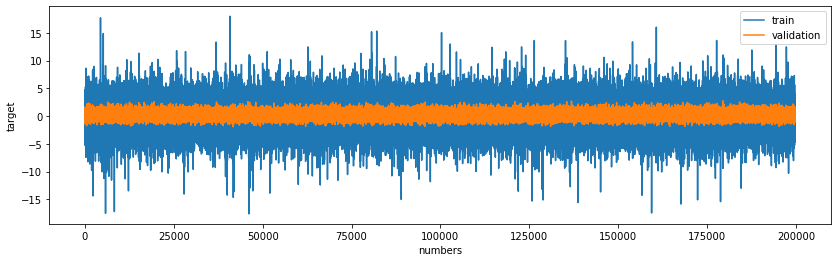

In [19]:
import matplotlib.pyplot as plt
def plot_train_validation(train, validation, target):
    plt.figure(figsize=(14,4))
    
    train_target = train[target]
    
    plt.plot(train_target, label='train')
    plt.plot(validation, label='validation')
    plt.xlabel("numbers")
    plt.ylabel(target)
    plt.legend()
    plt.show()

plot_train_validation(train, predictions, 'target')

From the plot above we can see our model is extremely underfitting. One reason is that we don't spend much time doing hyperparameter optimization, Another reason is that random forest itself is kind of bagging from multiple decision trees, doing kfolds on that won't differs anyway.

We will further train the dataset with boosting, please refers to our next topic